# 1. IMPORT

In [1]:
#필요한 모듈을 import 합니다.
from numba import cuda

#이후 초기화 작업을 진행해줍니다.
device = cuda.get_current_device()
device.reset()

In [2]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [3]:
from pytorchtools import EarlyStopping

In [4]:
from peft import (
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
    PeftModel, 
    PeftConfig,
)

peft_type = PeftType.LORA
peft_config = LoraConfig(task_type="SEQ_CLS",  r=8, lora_alpha=16, lora_dropout=0.1)

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim import AdamW

import matplotlib as mpl
import matplotlib.pyplot as plt

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings(action='ignore')


In [6]:
device = torch.device('cuda')if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [7]:
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


# 하이퍼파라미터 설정

In [8]:
import os
os.getcwd()

'/home/work/CL/lora_largecode2modify'

In [9]:
class config():
    def __init__(self):
        
        self.source_len=128
        self.epochs = 10
        self.learning_rate=0.0005
        self.batch_size=16
        self.shuffle = True
        self.seed=500
        self.num_labels=10
        self.data_path= '/home/work/CL/dataset/healthcare/healthcare5000.pickle'
        self.model_path = 'klue/roberta-large'
        # self.modelsave_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
        # self.loss_path = r'C:\Users\user\OneDrive - KookminUNIV\바탕 화면\추가사전학습\Fine_tuning'
cfg = config()

# 랜덤시드 고정

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.bachends.cudnn.bechmark = True
    
    seed_everything(cfg.seed) #seed 고정

# 데이터 로드

In [11]:
# trainset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
# testset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
# valset.to_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

trainset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_train.pickle')
testset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_test.pickle')
valset = pd.read_pickle('/home/work/CL/dataset/healthcare/healthcare_val.pickle')

In [12]:
trainset['수도라벨'].value_counts()

8    618
7    609
9    583
6    579
5    561
Name: 수도라벨, dtype: int64

In [13]:
for i in range(20):
    
    save_path = f"/home/work/CL/dataset/healthcare/16_desc{i+1}_combined.csv"
    globals()['trainset{}'.format(i+1)]= pd.read_csv(save_path)

# 토크나이저와 모델 정의

In [14]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, set_seed

model = AutoModelForSequenceClassification.from_pretrained(cfg.model_path, num_labels=cfg.num_labels, output_hidden_states=False).cuda()
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

model.resize_token_embeddings(len(tokenizer))
model

model_state_dict = torch.load("/home/work/CL/final_ictmodel/ict5epoch.pt", map_location=device)
model.load_state_dict(model_state_dict)
model = get_peft_model(model, peft_config).to(device)

model.print_trainable_parameters()
model


trainable params: 2,906,132 || all params: 338,512,916 || trainable%: 0.8584995911943283


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(32000, 1024, padding_idx=1)
          (position_embeddings): Embedding(514, 1024, padding_idx=1)
          (token_type_embeddings): Embedding(1, 1024)
          (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(
                    in_features=1024, out_features=1024, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (d

# 커스텀 데이터셋

In [15]:
class CustomDataset(Dataset):
    
    def __init__(self, data, labels, tokenizer, source_len) :
    # 내가 필요한 것들을 가져와서 선처리
        self.data = data.copy()
        self.labels = labels.copy()
        self.tokenizer = tokenizer
        self.source_len = source_len
    
    def __getitem__(self, index) :
    # 데이터 셋에서 한 개의 데이터를 가져오는 함수 정의
    
        text = self.data[index]
        inputs = self.tokenizer(text,max_length=self.source_len,padding='max_length',truncation=True, return_tensors='pt')
        # inputs = self.tokenizer.batch_encode_plus([text], max_length= self.source_len, truncation=True, padding='max_length',return_tensors='pt')
        label = self.labels[index]
        
        input_ids = inputs['input_ids'].squeeze()
        attention_mask = inputs['attention_mask'].squeeze()
        token_type_ids = inputs['token_type_ids'].squeeze()
        
        
        
    
        # input_ids = inputs['input_ids'][0]
        # attention_mask = inputs['attention_mask'][0]
        # token_type_ids = inputs['token_type_ids'][0]
        
        # return input_ids, attention_mask, token_type_ids, label
        
        inputs_dict = {
            'input_ids' : input_ids.to(device, dtype = torch.long),
            'attention_mask' : attention_mask.to(device, dtype = torch.long),
            'token_type_ids': token_type_ids.to(device, dtype = torch.long),
        }
        label = torch.tensor(label).to(device, dtype = torch.long)
        
        
        return inputs_dict, label
    
    def __len__(self) :
    # 데이터 셋의 길이
        return len(self.data)    

In [16]:
import pandas as pd

dataframes = []  # 데이터프레임 리스트 초기화

for i in range(1, 21):
    trainset = globals()[f"trainset{i}"]  # 동적으로 변수명을 활용하여 데이터프레임 가져오기
    dataframes.append(trainset)  # 데이터프레임 리스트에 추가

In [17]:
# 데이터프레임을 데이터셋으로 변환
datasets = []
for trainset in dataframes:
    dataset = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
                            labels=list(trainset['수도라벨'].copy()),
                            tokenizer=tokenizer,
                            source_len=cfg.source_len)
    datasets.append(dataset)

# 데이터로더 생성
batch_size = 16
data_loaders = []
for dataset in datasets:
    data_loader = DataLoader(dataset, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
    data_loaders.append(data_loader)
len(data_loaders)
# # 데이터로더 사용 예시
# for data_loader in data_loaders:
#     for batch in data_loader:
#         inputs_dict, label = batch
#         print(inputs_dict)
#         print(label)

20

In [18]:
# train_data = CustomDataset(data=list([str(i) for i in trainset['clean_text'].values.copy()].copy()),
#                            labels= list(trainset['수도라벨'].copy()),
#                            tokenizer= tokenizer,
#                            source_len= cfg.source_len)

val_data = CustomDataset(data=list([str(i) for i in valset['clean_text'].values.copy()].copy()),
                           labels= list(valset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)


test_data = CustomDataset(data=list([str(i) for i in testset['clean_text'].values.copy()].copy()),
                           labels= list(testset['수도라벨'].copy()),
                           tokenizer= tokenizer,
                           source_len= cfg.source_len)

# train_loader = DataLoader(train_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
val_loader = DataLoader(val_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)
test_loader = DataLoader(test_data, batch_size=cfg.batch_size, shuffle=False,num_workers=0)


# Train, val 정의

In [19]:
def train(epoch, model, optimizer, loader):
    
    model.train()
    total_loss, total_accuracy = 0,0
    nb_train_steps = 0
    for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
        outputs = model(**inputs, labels = labels)
        loss = outputs.loss
        

        pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
        true = [label for label in labels.cpu().numpy()]
        acc = accuracy_score(true,pred)
        

        if _%32 ==0 : #만약 인덱스가 10이 되면
            print(f'Epoch : {epoch+1}, train_{_}_step_loss : {loss.item()}')
            psuedo_pred = [logit.argmax().item() for logit in outputs.logits]
            psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(psuedo_pred))/len(labels)
            print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        total_accuracy += acc
        nb_train_steps += 1
    

    
    avg_loss = total_loss/len(loader)
    avg_acc = total_accuracy/nb_train_steps
    t_test_avg_acc = total_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, train_{_}_stepLoss:{avg_loss}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{avg_acc}')
    print(f'Epoch:{epoch+1}, train_{_}_stepacc:{t_test_avg_acc}')
    loss_dic['train_loss'].append(avg_loss)
    loss_dic['train_acc'].append(avg_acc)

In [20]:
def validate(epoch, model, loader):
   
    model.eval()
    eval_loss, eval_accuracy = 0,0
    nb_eval_steps = 0
    with torch.no_grad():
        for _,(inputs, labels) in enumerate(loader, 0): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            eval_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            acc = accuracy_score(true,pred)
            eval_accuracy += acc
            nb_eval_steps +=1
            if _%32 ==0 : #만약 인덱스가 10이 되면
                print(f'Epoch : {epoch+1}, val_{_}_step_loss : {loss.item()}')
                predicted_class_id = [logit.argmax().item() for logit in outputs.logits]
                psuedo_acc = np.sum(np.array(labels.to('cpu'))==np.array(predicted_class_id))/len(labels)
                print(f'{epoch+1}_{_}_step_정확도 :{psuedo_acc}')
                
                
    e_avg_loss = eval_loss/len(loader)
    e_avg_acc = eval_accuracy/nb_eval_steps
    e_test_avg_acc = eval_accuracy/len(loader)
    print(f'Epoch:{epoch+1}, val_{_}_stepLoss:{e_avg_loss}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_avg_acc}')
    print(f'Epoch:{epoch+1}, val_{_}_stepacc:{e_test_avg_acc}')

    loss_dic['validation_loss'].append(e_avg_loss)
    loss_dic['val_acc'].append(e_avg_acc)                
    loss_dic['epoch'].append(epoch+1)

    early_stopping(e_avg_loss, model)
    return e_avg_loss, e_test_avg_acc
    




In [21]:

def infer(model, loader):
    
    model.eval()
    test_loss, test_accuracy = 0,0
    result_dic = {'prediction':[], 'label':[]}
    with torch.no_grad():
        for _,(inputs, labels) in tqdm(enumerate(loader, 0)): 
        #enumerate는 인덱스까지 반환하는 함수(데이터, 스타트번호=0)
            outputs = model(**inputs, labels = labels)
            loss = outputs.loss
            test_loss += loss.item()

            pred = [logit.argmax().cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            result_dic['prediction'].append(pred)
            result_dic['label'].append(true)                

            acc = accuracy_score(true,pred)
            test_accuracy += acc
        
            
                
    t_avg_loss = test_loss/len(loader)
    t_avg_acc = test_accuracy/len(loader)
    print(f'test_{_}_stepLoss:{t_avg_loss}')
    print(f'test_{_}_stepacc:{t_avg_acc}')

    
    return t_avg_loss, t_avg_acc
    
        

# RUN

In [22]:
optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.0005)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0.* (len(data_loader) * cfg.epochs),
    num_training_steps=(len(data_loader) * cfg.epochs),
)

In [23]:
loss_dic = {'epoch':[],'train_loss':[], 'validation_loss':[],'train_acc':[],'val_acc':[]}
early_stopping = EarlyStopping(patience = 3, verbose = True)


for epoch in tqdm(range(0,cfg.epochs)):
    train(epoch, model, optimizer, data_loaders[epoch])
    lr_scheduler.step()

    validate(epoch, model, val_loader)
    
    # if early_stopping.early_stop:
    #     break
    torch.save(model, f'/home/work/CL/final_healthmodel/lora_desc_{epoch+1}epoch.pt')

    
    

df1 = pd.DataFrame(loss_dic)
df1.to_excel(f'/home/work/CL/final_healthmodel/lora_desc.xlsx', index=False)
    


  0% 0/10 [00:00<?, ?it/s]

Epoch : 1, train_0_step_loss : 6.154717445373535
1_0_step_정확도 :0.0
Epoch : 1, train_32_step_loss : 1.4647111892700195
1_32_step_정확도 :0.5
Epoch : 1, train_64_step_loss : 1.7105207443237305
1_64_step_정확도 :0.3125
Epoch : 1, train_96_step_loss : 0.4443129003047943
1_96_step_정확도 :0.875
Epoch : 1, train_128_step_loss : 1.1110706329345703
1_128_step_정확도 :0.4375
Epoch : 1, train_160_step_loss : 1.016047477722168
1_160_step_정확도 :0.625
Epoch:1, train_183_stepLoss:1.1190183472050272
Epoch:1, train_183_stepacc:0.5913722826086957
Epoch:1, train_183_stepacc:0.5913722826086957
Epoch : 1, val_0_step_loss : 0.4241197407245636
1_0_step_정확도 :0.75
Epoch : 1, val_32_step_loss : 1.2437081336975098
1_32_step_정확도 :0.5
Epoch:1, val_61_stepLoss:0.846976762817752
Epoch:1, val_61_stepacc:0.6732430875576038
Epoch:1, val_61_stepacc:0.6732430875576038
Validation loss decreased (inf --> 0.846977).  Saving model ...



 10% 1/10 [01:06<10:00, 66.75s/it]

Epoch : 2, train_0_step_loss : 0.6986250877380371
2_0_step_정확도 :0.8125
Epoch : 2, train_32_step_loss : 0.9210936427116394
2_32_step_정확도 :0.6875
Epoch : 2, train_64_step_loss : 1.1439683437347412
2_64_step_정확도 :0.5
Epoch : 2, train_96_step_loss : 0.5077854990959167
2_96_step_정확도 :0.875
Epoch : 2, train_128_step_loss : 0.6432072520256042
2_128_step_정확도 :0.5625
Epoch : 2, train_160_step_loss : 0.7844031453132629
2_160_step_정확도 :0.75
Epoch:2, train_183_stepLoss:0.8147818603269432
Epoch:2, train_183_stepacc:0.6681385869565217
Epoch:2, train_183_stepacc:0.6681385869565217
Epoch : 2, val_0_step_loss : 0.42823439836502075
2_0_step_정확도 :0.8125
Epoch : 2, val_32_step_loss : 1.2234052419662476
2_32_step_정확도 :0.5
Epoch:2, val_61_stepLoss:0.8432873617256841
Epoch:2, val_61_stepacc:0.6876440092165899
Epoch:2, val_61_stepacc:0.6876440092165899
Validation loss decreased (0.846977 --> 0.843287).  Saving model ...



 20% 2/10 [02:12<08:51, 66.42s/it]

Epoch : 3, train_0_step_loss : 0.504361629486084
3_0_step_정확도 :0.8125
Epoch : 3, train_32_step_loss : 0.6360342502593994
3_32_step_정확도 :0.8125
Epoch : 3, train_64_step_loss : 0.57422935962677
3_64_step_정확도 :0.75
Epoch : 3, train_96_step_loss : 0.36772608757019043
3_96_step_정확도 :0.875
Epoch : 3, train_128_step_loss : 0.767522394657135
3_128_step_정확도 :0.4375
Epoch : 3, train_160_step_loss : 0.678450345993042
3_160_step_정확도 :0.8125
Epoch:3, train_183_stepLoss:0.680142639528798
Epoch:3, train_183_stepacc:0.7245244565217391
Epoch:3, train_183_stepacc:0.7245244565217391
Epoch : 3, val_0_step_loss : 0.4726036787033081
3_0_step_정확도 :0.75
Epoch : 3, val_32_step_loss : 1.111824870109558
3_32_step_정확도 :0.5
Epoch:3, val_61_stepLoss:0.881541820062745
Epoch:3, val_61_stepacc:0.6836117511520737
Epoch:3, val_61_stepacc:0.6836117511520737
EarlyStopping counter: 1 out of 3



 30% 3/10 [03:15<07:32, 64.63s/it]

Epoch : 4, train_0_step_loss : 0.40537014603614807
4_0_step_정확도 :0.8125
Epoch : 4, train_32_step_loss : 0.705187976360321
4_32_step_정확도 :0.75
Epoch : 4, train_64_step_loss : 0.33470943570137024
4_64_step_정확도 :0.875
Epoch : 4, train_96_step_loss : 0.28466179966926575
4_96_step_정확도 :0.9375
Epoch : 4, train_128_step_loss : 0.6779015064239502
4_128_step_정확도 :0.5
Epoch : 4, train_160_step_loss : 0.7122340798377991
4_160_step_정확도 :0.8125
Epoch:4, train_183_stepLoss:0.5796241510821425
Epoch:4, train_183_stepacc:0.7713994565217391
Epoch:4, train_183_stepacc:0.7713994565217391
Epoch : 4, val_0_step_loss : 0.5375186204910278
4_0_step_정확도 :0.8125
Epoch : 4, val_32_step_loss : 1.4627175331115723
4_32_step_정확도 :0.5
Epoch:4, val_61_stepLoss:0.9637107344404343
Epoch:4, val_61_stepacc:0.7034850230414746
Epoch:4, val_61_stepacc:0.7034850230414746
EarlyStopping counter: 2 out of 3



 40% 4/10 [04:18<06:23, 63.88s/it]

Epoch : 5, train_0_step_loss : 0.3978956639766693
5_0_step_정확도 :0.8125
Epoch : 5, train_32_step_loss : 0.6686967015266418
5_32_step_정확도 :0.8125
Epoch : 5, train_64_step_loss : 0.3325560390949249
5_64_step_정확도 :0.8125
Epoch : 5, train_96_step_loss : 0.24339018762111664
5_96_step_정확도 :0.9375
Epoch : 5, train_128_step_loss : 0.27447983622550964
5_128_step_정확도 :0.9375
Epoch : 5, train_160_step_loss : 0.5461995601654053
5_160_step_정확도 :0.875
Epoch:5, train_183_stepLoss:0.46157032083315047
Epoch:5, train_183_stepacc:0.8206521739130435
Epoch:5, train_183_stepacc:0.8206521739130435
Epoch : 5, val_0_step_loss : 0.49108365178108215
5_0_step_정확도 :0.8125
Epoch : 5, val_32_step_loss : 1.258593201637268
5_32_step_정확도 :0.5
Epoch:5, val_61_stepLoss:1.0003354292242759
Epoch:5, val_61_stepacc:0.6957085253456221
Epoch:5, val_61_stepacc:0.6957085253456221
EarlyStopping counter: 3 out of 3



 50% 5/10 [05:21<05:17, 63.56s/it]

Epoch : 6, train_0_step_loss : 0.31346598267555237
6_0_step_정확도 :0.875
Epoch : 6, train_32_step_loss : 0.48535454273223877
6_32_step_정확도 :0.8125
Epoch : 6, train_64_step_loss : 0.2971269190311432
6_64_step_정확도 :0.875
Epoch : 6, train_96_step_loss : 0.3087986707687378
6_96_step_정확도 :0.875
Epoch : 6, train_128_step_loss : 0.4249598979949951
6_128_step_정확도 :0.75
Epoch : 6, train_160_step_loss : 0.7333903312683105
6_160_step_정확도 :0.8125
Epoch:6, train_183_stepLoss:0.40572501755441015
Epoch:6, train_183_stepacc:0.8525815217391305
Epoch:6, train_183_stepacc:0.8525815217391305
Epoch : 6, val_0_step_loss : 0.6881532669067383
6_0_step_정확도 :0.8125
Epoch : 6, val_32_step_loss : 1.807522177696228
6_32_step_정확도 :0.5
Epoch:6, val_61_stepLoss:1.1193905889747604
Epoch:6, val_61_stepacc:0.6949884792626728
Epoch:6, val_61_stepacc:0.6949884792626728
EarlyStopping counter: 4 out of 3



 60% 6/10 [06:23<04:13, 63.29s/it]

Epoch : 7, train_0_step_loss : 0.1297144591808319
7_0_step_정확도 :1.0
Epoch : 7, train_32_step_loss : 0.25190040469169617
7_32_step_정확도 :0.875
Epoch : 7, train_64_step_loss : 0.4175676107406616
7_64_step_정확도 :0.8125
Epoch : 7, train_96_step_loss : 0.3044835031032562
7_96_step_정확도 :0.8125
Epoch : 7, train_128_step_loss : 0.09450764209032059
7_128_step_정확도 :1.0
Epoch : 7, train_160_step_loss : 0.3420051038265228
7_160_step_정확도 :0.9375
Epoch:7, train_183_stepLoss:0.328316757293499
Epoch:7, train_183_stepacc:0.8787364130434783
Epoch:7, train_183_stepacc:0.8787364130434783
Epoch : 7, val_0_step_loss : 1.0197041034698486
7_0_step_정확도 :0.8125
Epoch : 7, val_32_step_loss : 2.143556594848633
7_32_step_정확도 :0.5
Epoch:7, val_61_stepLoss:1.27393674874498
Epoch:7, val_61_stepacc:0.6815956221198156
Epoch:7, val_61_stepacc:0.6815956221198156
EarlyStopping counter: 5 out of 3



 70% 7/10 [07:26<03:08, 62.95s/it]

Epoch : 8, train_0_step_loss : 0.3337404727935791
8_0_step_정확도 :0.75
Epoch : 8, train_32_step_loss : 0.3214052617549896
8_32_step_정확도 :0.8125
Epoch : 8, train_64_step_loss : 0.6775528788566589
8_64_step_정확도 :0.8125
Epoch : 8, train_96_step_loss : 0.16981229186058044
8_96_step_정확도 :0.9375
Epoch : 8, train_128_step_loss : 0.284493625164032
8_128_step_정확도 :0.875
Epoch : 8, train_160_step_loss : 0.40468543767929077
8_160_step_정확도 :0.875
Epoch:8, train_183_stepLoss:0.30951589325685863
Epoch:8, train_183_stepacc:0.8831521739130435
Epoch:8, train_183_stepacc:0.8831521739130435
Epoch : 8, val_0_step_loss : 0.8796654939651489
8_0_step_정확도 :0.8125
Epoch : 8, val_32_step_loss : 1.9658621549606323
8_32_step_정확도 :0.5
Epoch:8, val_61_stepLoss:1.4018579174674326
Epoch:8, val_61_stepacc:0.6815956221198156
Epoch:8, val_61_stepacc:0.6815956221198156
EarlyStopping counter: 6 out of 3



 80% 8/10 [08:29<02:05, 62.98s/it]

Epoch : 9, train_0_step_loss : 0.04209684580564499
9_0_step_정확도 :1.0
Epoch : 9, train_32_step_loss : 0.1649196743965149
9_32_step_정확도 :0.875
Epoch : 9, train_64_step_loss : 0.03368617594242096
9_64_step_정확도 :1.0
Epoch : 9, train_96_step_loss : 0.24863886833190918
9_96_step_정확도 :0.875
Epoch : 9, train_128_step_loss : 0.20365752279758453
9_128_step_정확도 :0.9375
Epoch : 9, train_160_step_loss : 0.14347730576992035
9_160_step_정확도 :0.9375
Epoch:9, train_183_stepLoss:0.2720808372326681
Epoch:9, train_183_stepacc:0.8987771739130435
Epoch:9, train_183_stepacc:0.8987771739130435
Epoch : 9, val_0_step_loss : 0.5959183573722839
9_0_step_정확도 :0.875
Epoch : 9, val_32_step_loss : 1.9849027395248413
9_32_step_정확도 :0.5625
Epoch:9, val_61_stepLoss:1.3007095833459208
Epoch:9, val_61_stepacc:0.6984447004608295
Epoch:9, val_61_stepacc:0.6984447004608295
EarlyStopping counter: 7 out of 3



 90% 9/10 [09:31<01:02, 62.90s/it]

Epoch : 10, train_0_step_loss : 0.052665919065475464
10_0_step_정확도 :1.0
Epoch : 10, train_32_step_loss : 0.17200256884098053
10_32_step_정확도 :0.9375
Epoch : 10, train_64_step_loss : 0.13959930837154388
10_64_step_정확도 :0.875
Epoch : 10, train_96_step_loss : 0.23653645813465118
10_96_step_정확도 :0.9375
Epoch : 10, train_128_step_loss : 0.13411736488342285
10_128_step_정확도 :0.875
Epoch : 10, train_160_step_loss : 0.3425259292125702
10_160_step_정확도 :0.9375
Epoch:10, train_183_stepLoss:0.23247185201667572
Epoch:10, train_183_stepacc:0.9184782608695652
Epoch:10, train_183_stepacc:0.9184782608695652
Epoch : 10, val_0_step_loss : 0.5806156992912292
10_0_step_정확도 :0.875
Epoch : 10, val_32_step_loss : 2.045677661895752
10_32_step_정확도 :0.5
Epoch:10, val_61_stepLoss:1.2916164487119643
Epoch:10, val_61_stepacc:0.691676267281106
Epoch:10, val_61_stepacc:0.691676267281106
EarlyStopping counter: 8 out of 3


100% 10/10 [10:34<00:00, 63.44s/it]


In [24]:
df1

,epoch,train_loss,validation_loss,train_acc,val_acc
0,1,1.119018,0.846977,0.591372,0.673243
1,2,0.814782,0.843287,0.668139,0.687644
2,3,0.680143,0.881542,0.724524,0.683612
3,4,0.579624,0.963711,0.771399,0.703485
4,5,0.461570,1.000335,0.820652,0.695709
5,6,0.405725,1.119391,0.852582,0.694988
6,7,0.328317,1.273937,0.878736,0.681596
7,8,0.309516,1.401858,0.883152,0.681596
8,9,0.272081,1.300710,0.898777,0.698445
9,10,0.232472,1.291616,0.918478,0.691676


In [25]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

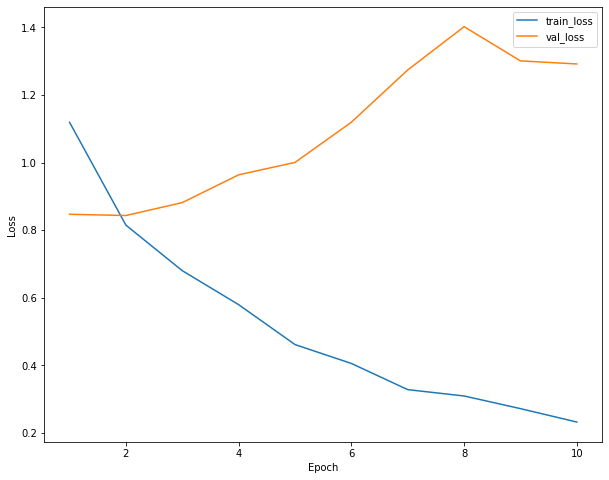

In [26]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss_dic['epoch'],loss_dic['train_loss'],label='train_loss')
plt.plot(loss_dic['epoch'],loss_dic['validation_loss'],label='val_loss')
# plt.plot(loss_dic['epoch'],nolora_df['train_loss'],label='no_lora_trainloss')
# plt.plot(loss_dic['epoch'],nolora_df['validation_loss'],label='no_lora_valloss')

plt.legend()
plt.show()

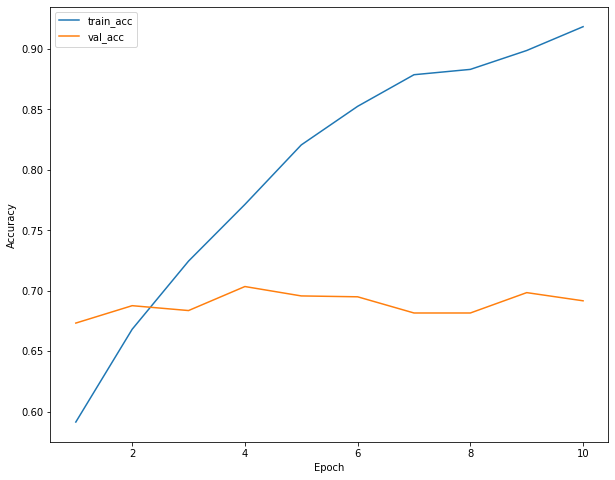

In [27]:
plt.figure(figsize=(10,8))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.plot(loss_dic['epoch'],loss_dic['train_acc'],label='train_acc')
plt.plot(loss_dic['epoch'],loss_dic['val_acc'],label='val_acc')
# plt.plot(loss_dic['epoch'],nolora_df['train_acc'],label='no_lora_train_acc')
# plt.plot(loss_dic['epoch'],nolora_df['val_acc'],label='no_lora_acc')
plt.legend()
plt.show()

## 2번 도메인까지 학습한뒤 평가(정렬된거기준)

### 1에폭 모델

In [28]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(cfg.model_path)

for i in range(20) :
    save_path = f"/home/work/CL/final_healthmodel/lora_desc_{i+1}epoch.pt"
    model = torch.load(save_path)

    print(i+1,infer(model=model,loader=test_loader))



62it [00:08,  7.62it/s]


test_61_stepLoss:0.7986541649987621
test_61_stepacc:0.6945564516129032
1 (0.7986541649987621, 0.6945564516129032)


62it [00:08,  7.60it/s]


test_61_stepLoss:0.7838105121927876
test_61_stepacc:0.6945564516129032
2 (0.7838105121927876, 0.6945564516129032)


62it [00:08,  7.57it/s]


test_61_stepLoss:0.7739005127260762
test_61_stepacc:0.6985887096774194
3 (0.7739005127260762, 0.6985887096774194)


62it [00:08,  7.57it/s]


test_61_stepLoss:0.8437486699511928
test_61_stepacc:0.719758064516129
4 (0.8437486699511928, 0.719758064516129)


62it [00:08,  7.57it/s]


test_61_stepLoss:0.9150554912705575
test_61_stepacc:0.7026209677419355
5 (0.9150554912705575, 0.7026209677419355)


62it [00:08,  7.58it/s]


test_61_stepLoss:0.9974284893082034
test_61_stepacc:0.7086693548387096
6 (0.9974284893082034, 0.7086693548387096)


62it [00:08,  7.60it/s]


test_61_stepLoss:1.1279879428686634
test_61_stepacc:0.6925403225806451
7 (1.1279879428686634, 0.6925403225806451)


62it [00:08,  7.63it/s]


test_61_stepLoss:1.2595948927825498
test_61_stepacc:0.6834677419354839
8 (1.2595948927825498, 0.6834677419354839)


62it [00:08,  7.59it/s]


test_61_stepLoss:1.1531955484421021
test_61_stepacc:0.7127016129032258
9 (1.1531955484421021, 0.7127016129032258)


62it [00:08,  7.54it/s]


test_61_stepLoss:1.1943927801424457
test_61_stepacc:0.7096774193548387
10 (1.1943927801424457, 0.7096774193548387)


FileNotFoundError: [Errno 2] No such file or directory: '/home/work/CL/final_healthmodel/lora_desc_11epoch.pt'